In [1]:
# Import and GPU Support
import matplotlib.pyplot as plt
import numpy as np
import torch
#from torch import linspace
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import time
import pickle

from E_data import create_residual_data, create_IC_data,create_BC_data, initial_u,Move_Time_1D,create_RH_data,Euler_WENO
from E_Plotting import E_plot,  loss_plot 
from E_solver import exact_solver

# Full PINN
#from E_PINN_WE import NN
#from E_PINN_train_plot import pinn_train

# TGPT-PINN
from E_TGPT_PINN_test import GPT
#from E_TGPT_train_test import gpt_train
from E_TGPT_PINNs import GPTs
from E_TGPT_train_minibatch import gpt_train
from E_TGPT_activation import P

#torch.set_default_dtype(torch.float)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"Current Device Name: {torch.cuda.get_device_name()}")

Current Device: cuda
Current Device Name: NVIDIA A100-SXM4-40GB


In [2]:
# Initial and Boundary Conditions
rhoL = 1.0
uL = 0.0
PL = 1.0
rhoR = 0.125
uR = 0.0
PR = 0.1
ini=[rhoL,PL,uL, rhoR,PR,uR]

# Domain and Data
Xi, Xf         =  0.0, 1.0
Ti, Tf         =  0.0, 0.1
Nc, N_test     =  100, 100
Tc, T_test     =  200, 100
N_simple       =  5000
IC_pts         =  100 
N_RH           =  100
dx = 0.01
dt = 0.002

gamma =1.4
number_of_parameters = 5
number_of_neurons = 5
nu_training = np.linspace(1,2, number_of_parameters)

residual_data = create_residual_data(Xi, Xf, Ti, Tf, Nc, N_test,Tc,T_test,N_simple)
xt_resid      = residual_data[0].to(device)
f_hat         = residual_data[1].to(device)
xt_test       = residual_data[2].to(device) 

xt_RH_data = create_RH_data(Xi, Xf, Ti, Tf, IC_pts, N_RH,dx)
xt_RH = xt_RH_data[0].to(device)
xt_RHL = xt_RH_data[1].to(device)

In [3]:
P_list = np.ones(number_of_neurons, dtype=object)
with open('PINNWE0410_Sod010_t01.pkl', 'rb') as f:
    PINN = pickle.load(f)
    P_list[0] = PINN
with open('PINNWE0410_Sod015_t01.pkl', 'rb') as f:
    PINN = pickle.load(f)
    P_list[1] = PINN
with open('PINNWE0410_Sod020_t01.pkl', 'rb') as f:
    PINN = pickle.load(f)
    P_list[2] = PINN
with open('PINNWE0410_Sod012_t01.pkl', 'rb') as f:
    PINN = pickle.load(f)
    P_list[3] = PINN
with open('PINNWE0410_Sod017_t01.pkl', 'rb') as f:
    PINN = pickle.load(f)
    P_list[4] = PINN

In [4]:
lr_pinn     = 0.001
epochs_pinn = [25000,20000,25000,25000]
layers_pinn = np.array([2, 60, 60,60,60,60, 3])
#layers_pinn = np.array([2, 30, 30,30,30, 3])
tol         = [1e-3,1e-4]

lr_tgpt          = 0.0001
epochs_tgpt      = [2000,10000]
tol_tgpt         = 1e-2

[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.2500, 0.2500, 0.2500, 0.2500]], device='cuda:0',
       dtype=torch.float64),tensor([[0.2500, 0.2500, 0.2500, 0.2500]], device='cuda:0',
       dtype=torch.float64),tensor([[0.2500, 0.2500, 0.2500, 0.2500]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]: Loss: 103.234185
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 103.2341847165269
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 17.585785
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 17.382330
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 1500 | Loss: 17.327351
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 17.275891
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[ 0.9838, -0.0021],
        [-0.0165,  1.0014]], device='cuda:0', dtype=torch.float64) and tensor([[0.2500, 0.2500, 0.2500, 0.2500]], device='cuda:0',
       dtype=torch.float64),tensor([[0.2500, 0.2500, 0.2500,

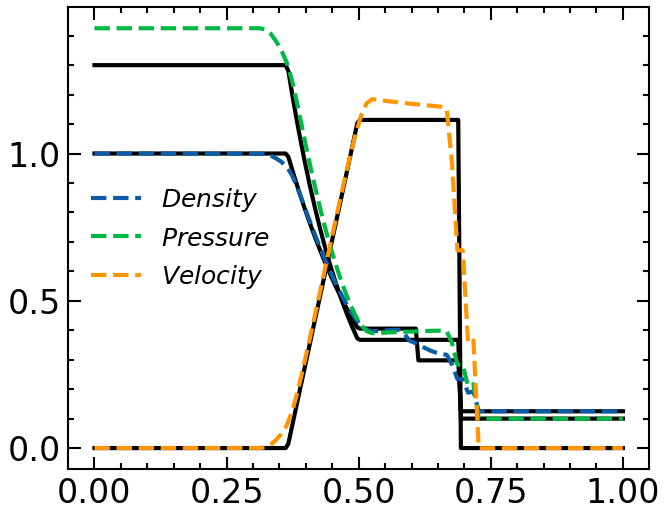

Step 2 Training Begin...
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0433e+00, -9.4682e-04],
        [-1.8961e-02,  9.9950e-01]], device='cuda:0', dtype=torch.float64) and tensor([[1.4330e-01, 9.0617e-02, 7.6422e-05, 7.6408e-01]], device='cuda:0',
       dtype=torch.float64),tensor([[0.2017, 0.0821, 0.0009, 0.8139]], device='cuda:0',
       dtype=torch.float64),tensor([[ 1.7471e-01,  8.9902e-02, -9.9706e-06,  7.8404e-01]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 3560 | Loss: 0.009405 (TGPT_PINN2 Step Criteria Met)



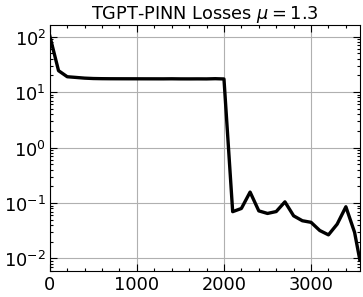

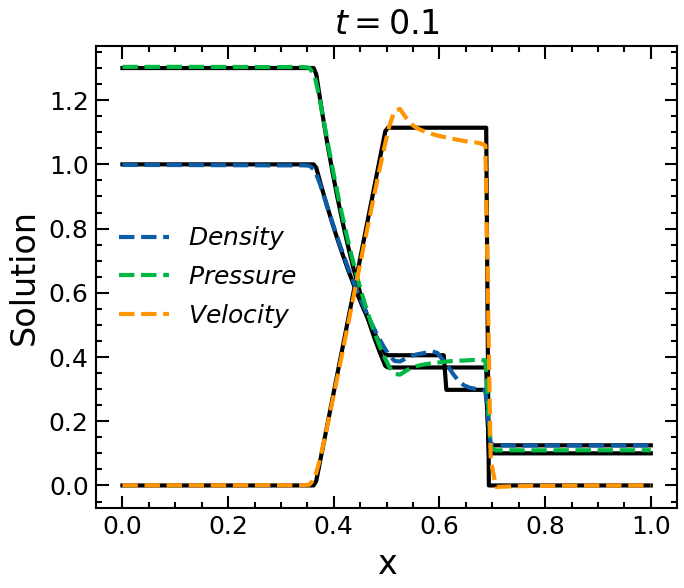

[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.2000, 0.2000, 0.2000, 0.2000, 0.2000]], device='cuda:0',
       dtype=torch.float64),tensor([[0.2000, 0.2000, 0.2000, 0.2000, 0.2000]], device='cuda:0',
       dtype=torch.float64),tensor([[0.2000, 0.2000, 0.2000, 0.2000, 0.2000]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]: Loss: 72.226925
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 72.226925265046
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 18.758282
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 18.616593
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 1500 | Loss: 18.612090
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 18.411139
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[ 0.9788, -0.0023],
        [-0.0304,  1.0013]], device='cuda:0', dtype=torch.float64) and tensor([[0.2000, 0.2000, 0.2000, 0.2000, 0.2000]], device='cuda:0',
       dtype=torch.float64),ten

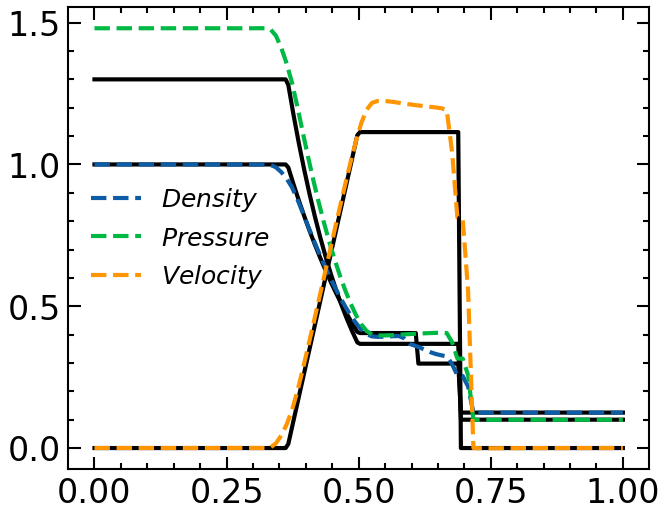

Step 2 Training Begin...
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[-0.0080,  2.5577],
        [ 0.1104,  6.5348]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0863, -0.0022],
        [-0.0463,  0.9988]], device='cuda:0', dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[0.3985, 0.0059, 0.0032, 0.5680, 0.0227]], device='cuda:0',
       dtype=torch.float64),tensor([[0.4887, 0.0236, 0.0033, 0.6154, 0.0133]], device='cuda:0',
       dtype=torch.float64),tensor([[4.4907e-01, 3.2851e-03, 8.9972e-03, 6.0611e-01, 1.5142e-05]],
       device='cuda:0', dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.105459


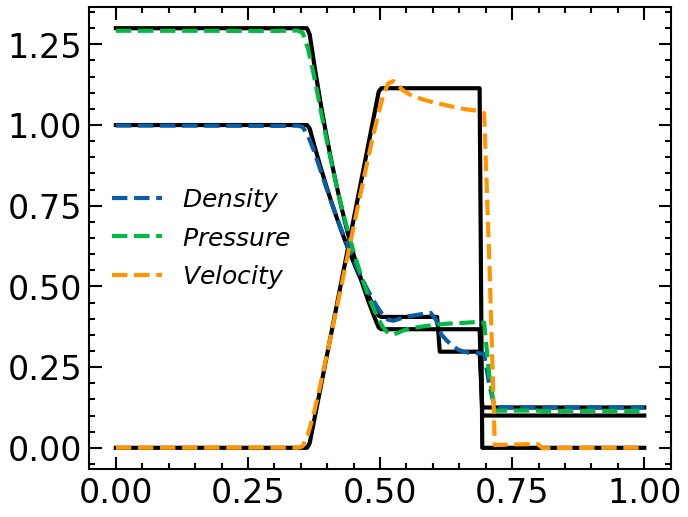

[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[-0.0234,  8.3298],
        [ 0.0606,  8.3153]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.1226, -0.0126],
        [-0.0101,  0.9995]], device='cuda:0', dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[0.3982, 0.4923, 0.0019, 0.1022, 0.0021]], device='cuda:0',
       dtype=torch.float64),tensor([[ 0.4894,  0.4397, -0.0007,  0.1114, -0.0030]], device='cuda:0',
       dtype=torch.float64),tensor([[0.4431, 0.4680, 0.0071, 0.0991, 0.0066]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 6000 | Loss: 0.061312


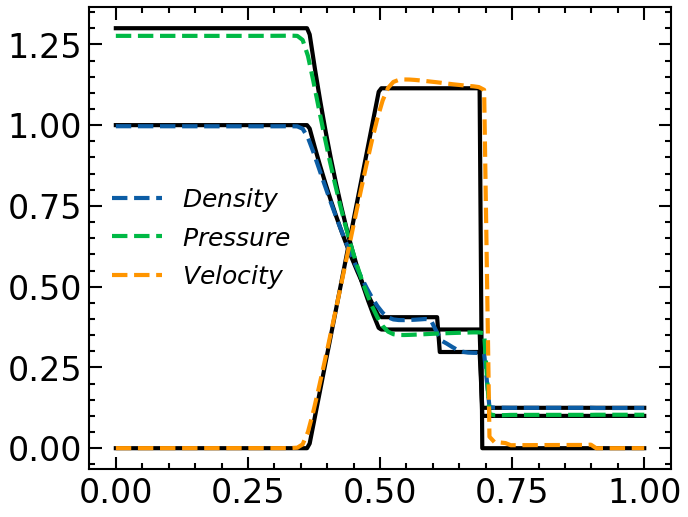

[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[  1.1562, -33.8713],
        [  0.9217, -45.1133]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.1328, -0.0077],
        [-0.0342,  1.0013]], device='cuda:0', dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[7.0900e-01, 1.5325e-01, 1.1388e-03, 1.3724e-01, 4.8248e-04]],
       device='cuda:0', dtype=torch.float64),tensor([[9.4030e-01, 1.2492e-01, 7.2248e-04, 1.2964e-01, 2.3210e-03]],
       device='cuda:0', dtype=torch.float64),tensor([[0.8251, 0.1215, 0.0013, 0.1449, 0.0027]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 8000 | Loss: 0.107444


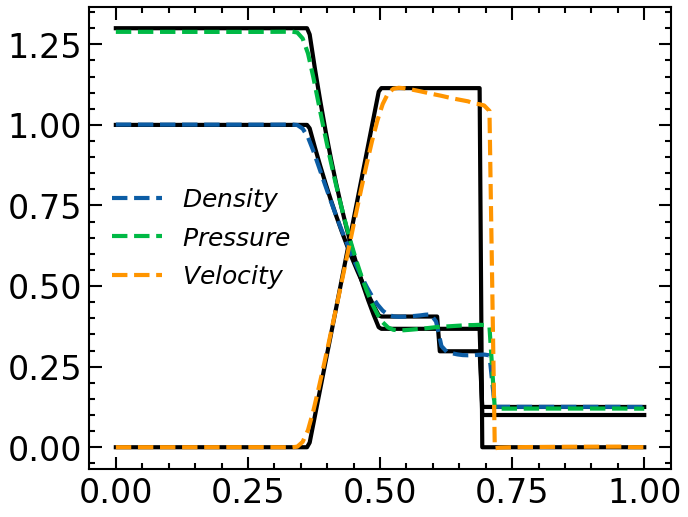

[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.1432, -0.0133],
        [-0.0365,  1.0036]], device='cuda:0', dtype=torch.float64) and tensor([[ 0.6530,  0.3324,  0.0041, -0.0011,  0.0021]], device='cuda:0',
       dtype=torch.float64),tensor([[ 8.3843e-01,  3.0441e-01, -7.5125e-04, -7.4689e-04,  1.3785e-03]],
       device='cuda:0', dtype=torch.float64),tensor([[ 0.7474,  0.3131,  0.0038, -0.0013,  0.0029]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 10000 | Loss: 0.050334 (TGPT_PINN2 Step Criteria Met)



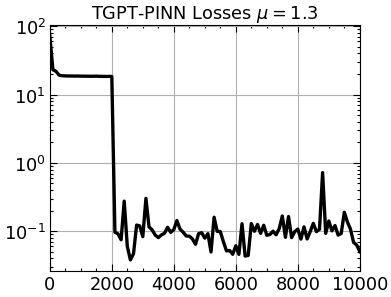

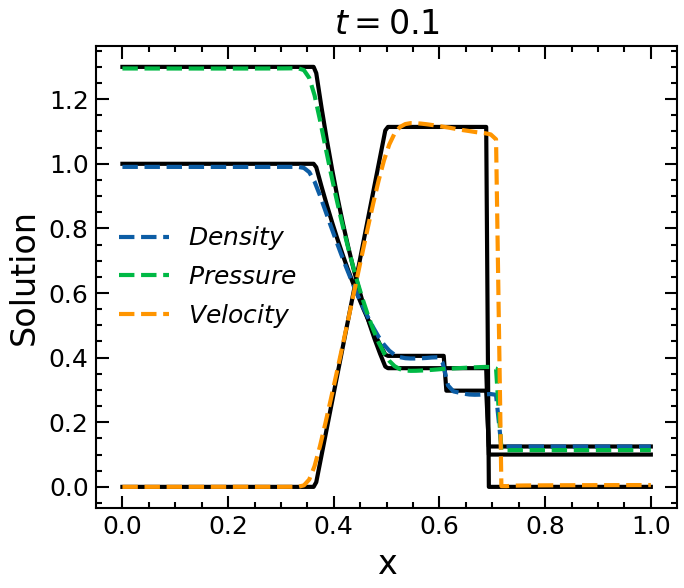

In [5]:
ini[1] = 1.3
weno_u = exact_solver([ini[0],ini[2],ini[1]],[ini[3],ini[5],ini[4]],gamma,Tf,N=200)
IC_data = create_IC_data(ini,Xi, Xf, Ti, Tf, IC_pts)
IC_xt     = IC_data[0].to(device)
IC_u      = IC_data[1]

BC_data = create_BC_data(ini,Xi, Xf, Ti, Tf, IC_pts)
BC_xt     = BC_data[0].to(device)
BC_u      = BC_data[1]

for i in range(3,number_of_neurons):
    layers_gpt = np.array([2, i+1, 3])
    c_initial  = torch.full((1,i+1), 1/(i+1))

    xt_en = Move_Time_1D(IC_xt, Tf).to(device)
    #weno_u = Euler_WENO(Xi,Xf,Ti,Tf,ini,gamma,delta_t=0.0001,delta_x=0.005)
    TGPT_PINN = GPT(ini, layers_gpt, P_list[0:i+1], c_initial, Nc, Tc, gamma,Tf).to(device).double()

    tgpt_losses = gpt_train(TGPT_PINN, ini, xt_resid,  IC_xt, IC_u,BC_xt, BC_u, f_hat,xt_test,xt_en, xt_RH, xt_RHL,weno_u,  epochs_tgpt, lr_tgpt, tol_tgpt)

    loss_plot(tgpt_losses[1], tgpt_losses[2], dpi=80, figsize=(5,4),title=fr"TGPT-PINN Losses $\mu={round(ini[1],3)}$")

    Nx_test=N_test
    Nt_test=T_test
    plt.figure(dpi=150, figsize=(5,4))

    ind = 100
    plt.plot(weno_u[3],weno_u[0],'k')#,label="$Density$"
    plt.plot(weno_u[3],weno_u[1],'k')#,label="$Pressure$"
    plt.plot(weno_u[3],weno_u[2],'k')#,label="$velocity$"

    #plt.plot(xt_test[0::Nt_test,1].detach().cpu(),P_list[0](xt_test)[:,0:1][ind-1::Nx_test].detach().cpu(),'k',label=fr"$Density$")
    #plt.plot(xt_test[0::Nt_test,1].detach().cpu(),P_list[0](xt_test)[:,1:2][ind-1::Nx_test].detach().cpu(),'k',label=fr"$Pressure$")
    #plt.plot(xt_test[0::Nt_test,1].detach().cpu(),P_list[0](xt_test)[:,2:][ind-1::Nx_test].detach().cpu(),'k',label=fr"$Velocity$")

    plt.plot(xt_test[0::Nt_test,1].detach().cpu(),TGPT_PINN(xt_test)[0][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Density$")
    plt.plot(xt_test[0::Nt_test,1].detach().cpu(),TGPT_PINN(xt_test)[1][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Pressure$")
    plt.plot(xt_test[0::Nt_test,1].detach().cpu(),TGPT_PINN(xt_test)[2][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Velocity$")
    plt.xlabel("x",     fontsize=16)
    plt.ylabel("Solution", fontsize=16)
    plt.title(fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)

    plt.legend(fontsize = 12)#
    plt.show()